### For updated features based on the ppp_transformed_updated.csv

Transformations include:
- Converting Term from numeric/ordinal to categorical (less than 24, 24, between 24 and 60, 60, more than 60)
    - Justification: most concentrated around 24 and 60. the standard for ppp is 24 months, but can be extended to 60 months
    - Could also see it as whether a loan extension was applied
- Log transformation on large numeric variables
    - Normalises the data before standardising
    - MinMax shrinks the range but preserves the skew
    - shrinking 0-1B to 0-1 results in long decimals (eg. 0.988887622845627891), which usually gets binned together
    - new columns will be standardised as well
- Including dummy variables 
- Splitting dataset based on original (non-categorical), encoded, scaled_standardised, log_standardised, dummy

In [41]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings(action = 'ignore', category = UserWarning)

In [42]:
df = pd.read_csv("C:/Users/wei-z/OneDrive - Singapore Management University/Sch Docs/IS424 Data Mining/project/PPP/ppp_transformed_updated.csv")
df_original = df.copy()
df.columns

Index(['LoanNumber', 'DateApproved', 'SBAOfficeCode', 'ProcessingMethod',
       'BorrowerName', 'BorrowerCity', 'BorrowerState', 'BorrowerZip',
       'LoanStatus', 'Term', 'InitialApprovalAmount', 'CurrentApprovalAmount',
       'FranchiseName', 'ServicingLenderName', 'ServicingLenderZip',
       'RuralUrbanIndicator', 'HubzoneIndicator', 'LMIIndicator',
       'BusinessAgeDescription', 'ProjectCity', 'JobsReported', 'NAICSCode',
       'Race', 'Ethnicity', 'BusinessType', 'Gender', 'Veteran',
       'TOTAL_PROCEED', 'PROCEED_Diff', 'UTILITIES_PROCEED_pct',
       'PAYROLL_PROCEED_pct', 'MORTGAGE_INTEREST_PROCEED_pct',
       'RENT_PROCEED_pct', 'REFINANCE_EIDL_PROCEED_pct',
       'HEALTH_CARE_PROCEED_pct', 'DEBT_INTEREST_PROCEED_pct',
       'PROCEED_Per_Job', 'isAfterBiden', 'isDiffBorrowerAndProjectCity',
       'Industry', 'Subsector', 'ProcessingMethod_encoded',
       'LoanStatus_encoded', 'RuralUrbanIndicator_encoded',
       'HubzoneIndicator_encoded', 'LMIIndicator_encoded'

#### Converting 'Term' to categorical

In [43]:
def term_transform(row):
    """
    Transforms 'Term' column into a new column with categorical (string) values
    > 60  : more than 60
    == 60 : 60
    > 24  : between 24 and 60
    == 24 : 24
    < 24  : less than 24 
    """
    if row > 60:
        label = 'more_than_60'
    elif row == 60:
        label = 'is_60'
    elif row > 24:
        label = 'between_24_60'
    elif row == 24:
        label = 'is_24'
    else:
        label = 'less_than_24'
    return label

In [44]:
# transform Term column into categorical
df['Term_cat'] = df['Term'].apply(term_transform)
df[['Term', 'Term_cat']].head(5)

,Term,Term_cat
0,24,is_24
1,24,is_24
2,24,is_24
3,24,is_24
4,24,is_24


### Log-transform 'InitialApprovalAmount','CurrentApprovalAmount','TOTAL_PROCEED','PROCEED_Per_Job','JobsReported'
'PROCEED_Diff' not log-transformed due to log(0) resulting in -inf, please use the original scaled_standard

In [45]:
# following variables are significantly large in scale
big = ['InitialApprovalAmount','CurrentApprovalAmount','TOTAL_PROCEED','PROCEED_Per_Job','JobsReported']

for var in big:
    #df[f'log_{var}'] = np.log(df[var]) 
    df[f'log_{var}'] = [np.log(x) if x > 0 else 0 for x in df[var]]

### Standardising log-transformed variables

In [47]:
log_to_standardise = ['log_InitialApprovalAmount','log_CurrentApprovalAmount', 'log_TOTAL_PROCEED','log_PROCEED_Per_Job']

scaler = StandardScaler()

for field in log_to_standardise:
    df[f'{field}_standardised'] = scaler.fit_transform(df[[field]])

### Percentages variables transformation

Since all _pct variables are summed to 1 for each row, and noticing that most rows have 1 to PAYROLL_PROCEED_pct (indicating 100% allocation to payroll), we will take a ratio of proceeds that went to payroll versus proceeds that went to all other aspects. 

The formula: ln((1+payroll_proceed_pct)/(1+sum(all other pct)))

1 is added to numerator and denominator to aid in calculation

In [48]:
payroll_scaler = StandardScaler()

df['payroll_over_other'] = np.log((1+df['PAYROLL_PROCEED_pct'])/(1+df[['UTILITIES_PROCEED_pct','MORTGAGE_INTEREST_PROCEED_pct','RENT_PROCEED_pct',
                                                                       'REFINANCE_EIDL_PROCEED_pct','HEALTH_CARE_PROCEED_pct','DEBT_INTEREST_PROCEED_pct'
                                                                       ]].sum(axis=1)))

df['payroll_over_other'] = payroll_scaler.fit_transform(df['payroll_over_other'].values.reshape((-1, 1)))

Just for clarity, the dataframes will be split into 

1. Original dataset as loaded (df_original)
2. Dataset as transformed up to now (df_new)

Lists of various variables are provided, please feel free to drop accordingly.

If your model requires dummy variables, please use the next section.

In [50]:
# list of encoded variables
encoded = ['ProcessingMethod_encoded','LoanStatus_encoded','RuralUrbanIndicator_encoded','HubzoneIndicator_encoded','LMIIndicator_encoded',
           'BusinessAgeDescription_encoded','Race_encoded','Ethnicity_encoded','BusinessType_encoded','Gender_encoded','Veteran_encoded','Industry_encoded']

# list of existing standardised variables
standardised = ['Term_standardised','JobsReported_standardised','UTILITIES_PROCEED_pct_standardised','PAYROLL_PROCEED_pct_standardised',
                'MORTGAGE_INTEREST_PROCEED_pct_standardised','RENT_PROCEED_pct_standardised','REFINANCE_EIDL_PROCEED_pct_standardised','HEALTH_CARE_PROCEED_pct_standardised',
                'DEBT_INTEREST_PROCEED_pct_standardised','InitialApprovalAmount_scaled_standardised','CurrentApprovalAmount_scaled_standardised','TOTAL_PROCEED_scaled_standardised',
                'PROCEED_Per_Job_scaled_standardised']

# list of log_transformed variables
logged = ['log_InitialApprovalAmount','log_CurrentApprovalAmount','log_TOTAL_PROCEED','log_PROCEED_Per_Job','log_JobsReported']

# list of log_transformed_standardised variables
log_standardise = ['log_InitialApprovalAmount_standardised','log_CurrentApprovalAmount_standardised','log_TOTAL_PROCEED_standardised',
                   'log_PROCEED_Per_Job_standardised','log_JobsReported_standardised']

# list of pct variables
pct = ['PAYROLL_PROCEED_pct','UTILITIES_PROCEED_pct','MORTGAGE_INTEREST_PROCEED_pct','RENT_PROCEED_pct','REFINANCE_EIDL_PROCEED_pct','HEALTH_CARE_PROCEED_pct','DEBT_INTEREST_PROCEED_pct']

# list of commonly dropped varibles (please feel free to use your own)
drop = ['LoanNumber','DateApproved','SBAOfficeCode','BorrowerName','BorrowerCity','BorrowerZip','Term','InitialApprovalAmount','CurrentApprovalAmount',
        'FranchiseName','ServicingLenderName','ServicingLenderZip','ProjectCity','NAICSCode','TOTAL_PROCEED','PROCEED_Diff','JobsReported','PROCEED_Per_Job','Subsector']

# original dataframe from ppp_transformed_updated.csv
# df_original

# original dataframe with Term transformation, log transformation, log standardised and dummies -> new dataframe transformed up to now
df_new = df.copy()

In [51]:
# drop columns that are not required in your model
df = df_new.drop(encoded+standardised+logged+pct+drop, axis = 1)

### Creating dummy variables

In [53]:
df = df # please add the dataframe you are using

dummies = ['ProcessingMethod','LoanStatus','RuralUrbanIndicator','HubzoneIndicator',
           'LMIIndicator','BusinessAgeDescription','Race','Ethnicity','BusinessType','Gender',
           'Veteran','isAfterBiden','isDiffBorrowerAndProjectCity','Industry','BorrowerState','Term_cat']

df_no_dummies = df.copy()
df = pd.get_dummies(df, columns = dummies)

df.columns

Index(['PROCEED_Diff_standardised', 'isFraud',
       'log_InitialApprovalAmount_standardised',
       'log_CurrentApprovalAmount_standardised',
       'log_TOTAL_PROCEED_standardised', 'log_PROCEED_Per_Job_standardised',
       'payroll_over_other', 'ProcessingMethod_PPP', 'ProcessingMethod_PPS',
       'LoanStatus_Active Un-Disbursed',
       ...
       'BorrowerState_VT', 'BorrowerState_WA', 'BorrowerState_WI',
       'BorrowerState_WV', 'BorrowerState_WY', 'Term_cat_between_24_60',
       'Term_cat_is_24', 'Term_cat_is_60', 'Term_cat_less_than_24',
       'Term_cat_more_than_60'],
      dtype='object', length=154)

### Modelling data preparation

In [54]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, Lasso, LassoCV, LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, roc_auc_score, RocCurveDisplay, auc
from sklearn.model_selection import GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [55]:
# split train-test dataset
X = df.drop('isFraud', axis = 1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 99)

In [56]:
# apply oversamppling through SMOTE
smote = SMOTE(random_state = 99)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

y_train_resampled.value_counts()

isFraud
0    769095
1    769095
Name: count, dtype: int64

In [57]:
# apply undersampling through RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy = 0.5, random_state = 99)
X_train_undersampled, y_train_undersampled = undersample.fit_resample(X_train, y_train)

X_train_undersampled.shape

(1254, 153)

In [58]:
# ROC AUC function
def plot_score_roc_auc(y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc).plot()
    plt.show()

#### Ridge Classifier

In [59]:
# train ridge classifier model
ridge_classifier = RidgeClassifier(alpha = 1.0, solver = 'auto')

ridge_classifier.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred_ridge = ridge_classifier.predict(X_test)

accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
classification_report_result_ridge = classification_report(y_test, y_pred_ridge)

print(f'Accuracy: {accuracy_ridge}')
print(f'Classification Report:\n{classification_report_result_ridge}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_ridge))

Accuracy: 0.9963873395744858
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.12      0.91      0.22       105

    accuracy                           1.00    192379
   macro avg       0.56      0.96      0.61    192379
weighted avg       1.00      1.00      1.00    192379

[[191588    686]
 [     9     96]]


In [60]:
# train ridge classifier model
ridge_classifier = RidgeClassifier(alpha = 1.0, solver = 'auto')

ridge_classifier.fit(X_train_undersampled, y_train_undersampled)

# model evaluation
y_pred_ridge = ridge_classifier.predict(X_test)

accuracy_ridge = accuracy_score(y_test, y_pred_ridge)
classification_report_result_ridge = classification_report(y_test, y_pred_ridge)

print(f'Accuracy: {accuracy_ridge}')
print(f'Classification Report:\n{classification_report_result_ridge}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_ridge))

Accuracy: 0.989442714641411
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    192274
           1       0.05      0.96      0.09       105

    accuracy                           0.99    192379
   macro avg       0.52      0.98      0.54    192379
weighted avg       1.00      0.99      0.99    192379

[[190247   2027]
 [     4    101]]


#### LASSO

In [61]:
# train lasso model
lasso_regression = Lasso(alpha = 0.1)

lasso_regression.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred_lasso = lasso_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_lasso_binary = [1 if i > 0.5 else 0 for i in y_pred_lasso]

# generate accuracy and classification report
accuracy_lasso = accuracy_score(y_test, y_pred_lasso_binary)
classification_report_result_lasso = classification_report(y_test, y_pred_lasso_binary)

print(f'Accuracy: {accuracy_lasso}')
print(f'Classification Report:\n{classification_report_result_lasso}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_lasso_binary))

Accuracy: 0.9974321521579799
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.16      0.90      0.28       105

    accuracy                           1.00    192379
   macro avg       0.58      0.95      0.64    192379
weighted avg       1.00      1.00      1.00    192379

[[191790    484]
 [    10     95]]


In [62]:
# train lasso model
lasso_regression = Lasso(alpha = 0.1)

lasso_regression.fit(X_train_undersampled, y_train_undersampled)

# model evaluation
y_pred_lasso = lasso_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_lasso_binary = [1 if i > 0.5 else 0 for i in y_pred_lasso]

# generate accuracy and classification report
accuracy_lasso = accuracy_score(y_test, y_pred_lasso_binary)
classification_report_result_lasso = classification_report(y_test, y_pred_lasso_binary)

print(f'Accuracy: {accuracy_lasso}')
print(f'Classification Report:\n{classification_report_result_lasso}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_lasso_binary))

Accuracy: 0.9974321521579799
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.16      0.90      0.28       105

    accuracy                           1.00    192379
   macro avg       0.58      0.95      0.64    192379
weighted avg       1.00      1.00      1.00    192379

[[191790    484]
 [    10     95]]


#### Logistic Regression

For both over and undersampling, as well as l1 and l2 penalties. 

In [63]:
# train logistic model
logist_regression = LogisticRegression(penalty='l2', solver='saga')

logist_regression.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred_logist = logist_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_logist_binary = [1 if i > 0.5 else 0 for i in y_pred_logist]

# generate accuracy and classification report
accuracy_logist = accuracy_score(y_test, y_pred_logist_binary)
classification_report_result_logist = classification_report(y_test, y_pred_logist_binary)

print(f'Accuracy: {accuracy_logist}')
print(f'Classification Report:\n{classification_report_result_logist}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_logist_binary))

Accuracy: 0.9896194491082706
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    192274
           1       0.05      0.97      0.09       105

    accuracy                           0.99    192379
   macro avg       0.52      0.98      0.54    192379
weighted avg       1.00      0.99      0.99    192379

[[190280   1994]
 [     3    102]]


In [64]:
# train logistic model
logist_regression = LogisticRegression(penalty='l2', solver='saga')

logist_regression.fit(X_train_undersampled, y_train_undersampled)

# model evaluation
y_pred_logist = logist_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_logist_binary = [1 if i > 0.5 else 0 for i in y_pred_logist]

# generate accuracy and classification report
accuracy_logist = accuracy_score(y_test, y_pred_logist_binary)
classification_report_result_logist = classification_report(y_test, y_pred_logist_binary)

print(f'Accuracy: {accuracy_logist}')
print(f'Classification Report:\n{classification_report_result_logist}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_logist_binary))

Accuracy: 0.9822745725884842
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    192274
           1       0.03      0.99      0.06       105

    accuracy                           0.98    192379
   macro avg       0.51      0.99      0.52    192379
weighted avg       1.00      0.98      0.99    192379

[[188865   3409]
 [     1    104]]


In [65]:
# train logistic model
logist_regression = LogisticRegression(penalty='l1', solver='saga')

logist_regression.fit(X_train_resampled, y_train_resampled)

# model evaluation
y_pred_logist = logist_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_logist_binary = [1 if i > 0.5 else 0 for i in y_pred_logist]

# generate accuracy and classification report
accuracy_logist = accuracy_score(y_test, y_pred_logist_binary)
classification_report_result_logist = classification_report(y_test, y_pred_logist_binary)

print(f'Accuracy: {accuracy_logist}')
print(f'Classification Report:\n{classification_report_result_logist}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_logist_binary))

Accuracy: 0.9896246471808253
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    192274
           1       0.05      0.97      0.09       105

    accuracy                           0.99    192379
   macro avg       0.52      0.98      0.54    192379
weighted avg       1.00      0.99      0.99    192379

[[190281   1993]
 [     3    102]]


In [66]:
# train logistic model
logist_regression = LogisticRegression(penalty='l1', solver='saga')

logist_regression.fit(X_train_undersampled, y_train_undersampled)

# model evaluation
y_pred_logist = logist_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_logist_binary = [1 if i > 0.5 else 0 for i in y_pred_logist]

# generate accuracy and classification report
accuracy_logist = accuracy_score(y_test, y_pred_logist_binary)
classification_report_result_logist = classification_report(y_test, y_pred_logist_binary)

print(f'Accuracy: {accuracy_logist}')
print(f'Classification Report:\n{classification_report_result_logist}')

# confusion matrix
print(confusion_matrix(y_test, y_pred_logist_binary))

Accuracy: 0.9805488125003249
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    192274
           1       0.03      0.99      0.05       105

    accuracy                           0.98    192379
   macro avg       0.51      0.99      0.52    192379
weighted avg       1.00      0.98      0.99    192379

[[188533   3741]
 [     1    104]]


### Ridge Classifier Hyperparameter Tuning

#### Ridge Classifier Model oversampled

In [67]:
# param_grid alpha values
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.02)

ridge = RidgeClassifier()
ridge_model1 = GridSearchCV(ridge, param_grid=grid, scoring='roc_auc', cv = 10)
ridge_model1.fit(X_train_resampled, y_train_resampled)

# predict y values based on lasso model
y_pred = ridge_model1.predict(X_test)

C:\Users\wei-z\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.41218e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
C:\Users\wei-z\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_ridge.py:211: LinAlgWarning: Ill-conditioned matrix (rcond=7.4113e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


In [68]:
# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Alpha: {ridge_model1.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print(confusion_matrix(y_test, y_pred))

Alpha: {'alpha': 0.02}
Accuracy: 0.9963873395744858
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.12      0.91      0.22       105

    accuracy                           1.00    192379
   macro avg       0.56      0.96      0.61    192379
weighted avg       1.00      1.00      1.00    192379

[[191588    686]
 [     9     96]]


In [69]:
# save model
joblib.dump(ridge_model1, 'ridge_model_oversampled.pkl')

['ridge_model_oversampled.pkl']

In [70]:
# load model
ridge_model1 = joblib.load('ridge_model_oversampled.pkl')

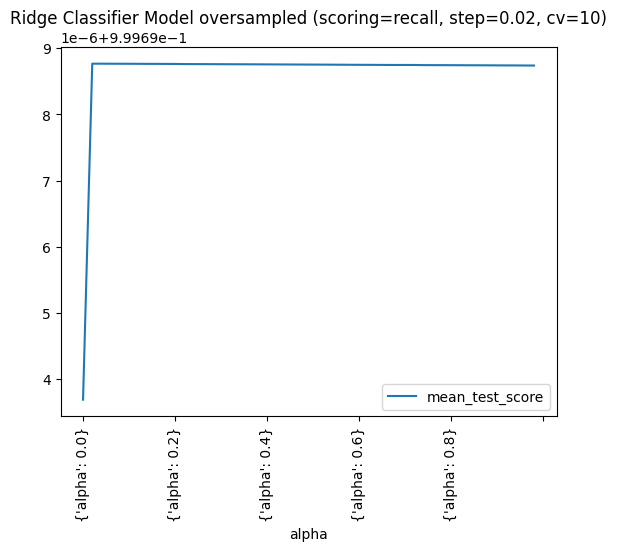

In [71]:
results = pd.DataFrame(ridge_model1.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]
results.plot(x = 'params', y = 'mean_test_score')
plt.title('Ridge Classifier Model oversampled (scoring=recall, step=0.02, cv=10)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

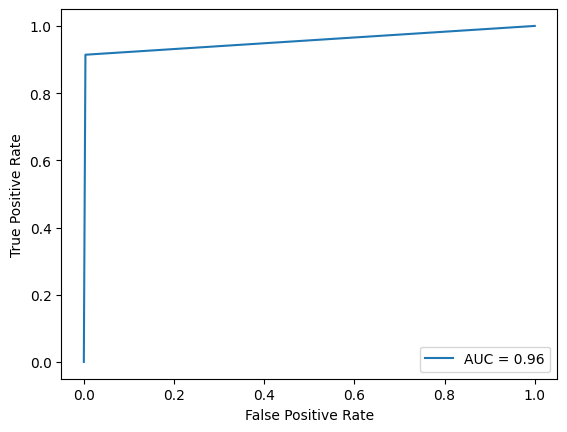

In [72]:
plot_score_roc_auc(y_pred)

In [73]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':ridge_model1.feature_names_in_,'coef':ridge_model1.best_estimator_.coef_[0]})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
91,BorrowerState_AK,1.537931,1.537931
25,Race_Eskimo & Aleut,-1.289539,1.289539
139,BorrowerState_UNK,0.923285,0.923285
151,Term_cat_less_than_24,0.793207,0.793207
99,BorrowerState_DC,0.679254,0.679254
74,Industry_Construction,0.410003,0.410003
87,Industry_Retail trade,0.399456,0.399456
73,"Industry_Arts, entertainment, and recreation",0.395405,0.395405
6,ProcessingMethod_PPP,0.386334,0.386334
77,Industry_Health care and social assistance,0.375370,0.375370


#### Ridge Classifier Model undersampled

In [74]:
# param_grid alpha values
grid = dict()
grid['alpha'] = np.arange(0, 1, 0.02)

ridge = RidgeClassifier()
ridge_model2 = GridSearchCV(ridge, param_grid=grid, scoring='roc_auc', cv = 10)
ridge_model2.fit(X_train_undersampled, y_train_undersampled)

# predict y values based on lasso model
y_pred = ridge_model2.predict(X_test)

In [75]:
# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred)
classification_report_result = classification_report(y_test, y_pred)

print(f"Alpha: {ridge_model2.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print(confusion_matrix(y_test, y_pred))

Alpha: {'alpha': 0.9}
Accuracy: 0.9894323184963015
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    192274
           1       0.05      0.96      0.09       105

    accuracy                           0.99    192379
   macro avg       0.52      0.98      0.54    192379
weighted avg       1.00      0.99      0.99    192379

[[190245   2029]
 [     4    101]]


In [76]:
# save model
joblib.dump(ridge_model2, 'ridge_model_undersampled.pkl')

['ridge_model_undersampled.pkl']

In [77]:
ridge_model2 = joblib.load('ridge_model_undersampled.pkl')

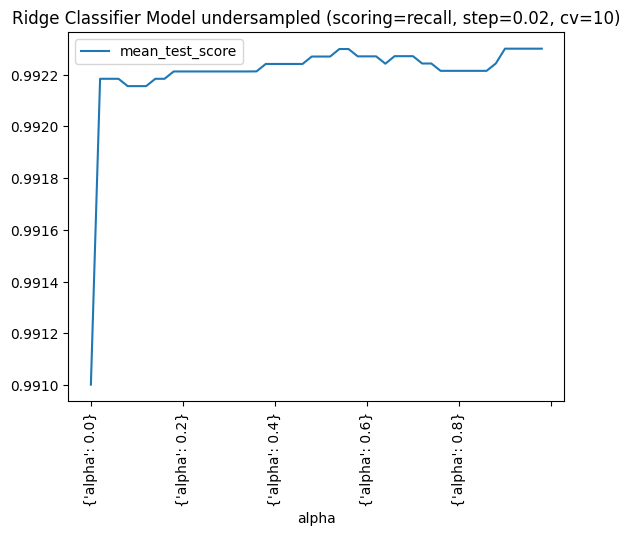

In [78]:
results = pd.DataFrame(ridge_model2.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

results.plot(x = 'params', y = 'mean_test_score')
plt.title('Ridge Classifier Model undersampled (scoring=recall, step=0.02, cv=10)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

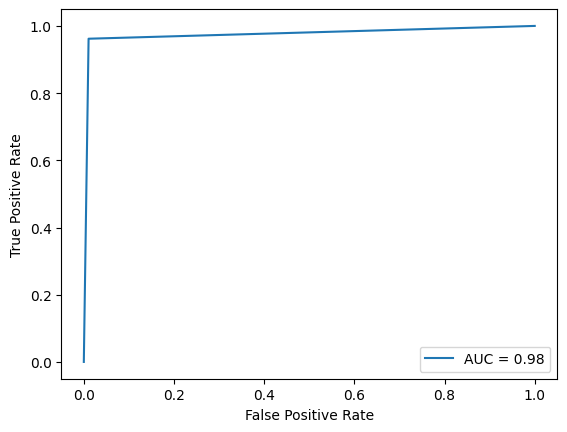

In [79]:
plot_score_roc_auc(y_pred)

In [80]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':ridge_model2.feature_names_in_,'coef':ridge_model2.best_estimator_.coef_[0]})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
91,BorrowerState_AK,1.815228,1.815228
139,BorrowerState_UNK,1.660253,1.660253
52,BusinessType_Self-Employed Individuals,0.627034,0.627034
99,BorrowerState_DC,0.574780,0.574780
149,Term_cat_is_24,-0.487191,0.487191
148,Term_cat_between_24_60,0.452101,0.452101
151,Term_cat_less_than_24,0.359151,0.359151
150,Term_cat_is_60,-0.324062,0.324062
144,BorrowerState_WA,-0.227887,0.227887
114,BorrowerState_ME,-0.225270,0.225270


### Lasso Hyperparameter Tuning

#### Lasso Model oversampled

In [81]:
# param_grid alpha values
grid = {'alpha': np.arange(0, 1, 0.02)}
# grid['alpha'] = np.arange(0, 1, 0.05)

lasso = Lasso()
lasso_model1 = GridSearchCV(lasso, param_grid=grid, scoring='neg_mean_squared_error', cv = 10)
lasso_model1.fit(X_train_resampled, y_train_resampled)

# predict y values based on lasso model
y_pred = lasso_model1.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]

In [82]:
# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_binary)
classification_report_result = classification_report(y_test, y_pred_binary)

print(f"Alpha: {lasso_model1.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print(confusion_matrix(y_test, y_pred_binary))

Alpha: {'alpha': 0.0}
Accuracy: 0.9963873395744858
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    192274
           1       0.12      0.91      0.22       105

    accuracy                           1.00    192379
   macro avg       0.56      0.96      0.61    192379
weighted avg       1.00      1.00      1.00    192379

[[191588    686]
 [     9     96]]


In [83]:
# save model
joblib.dump(lasso_model1, 'lasso_model_oversampled.pkl')

['lasso_model_oversampled.pkl']

In [84]:
lasso_model1 = joblib.load('lasso_model_oversampled.pkl')

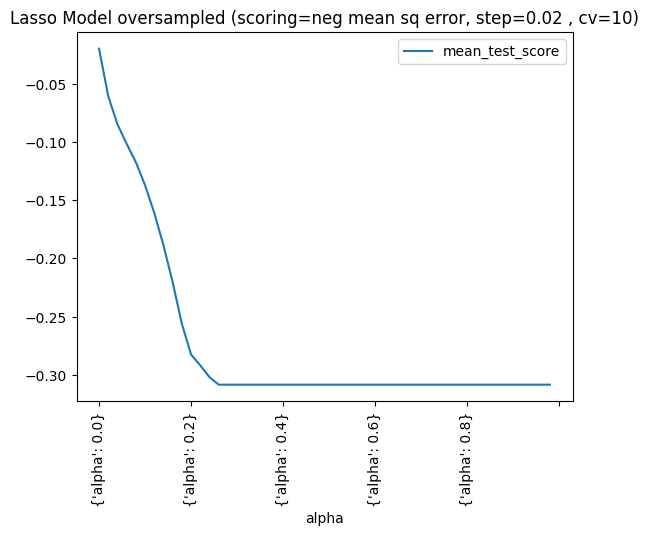

In [85]:
results = pd.DataFrame(lasso_model1.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

results.plot(x = 'params', y = 'mean_test_score')
plt.title('Lasso Model oversampled (scoring=neg mean sq error, step=0.02 , cv=10)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

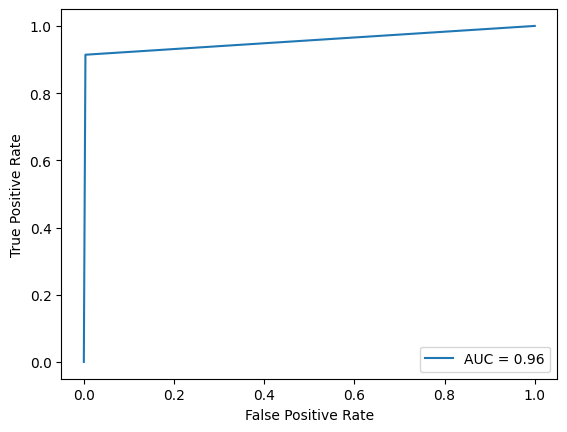

In [86]:
plot_score_roc_auc(y_pred_binary)

In [87]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':lasso_model1.feature_names_in_,'coef':lasso_model1.best_estimator_.coef_})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
91,BorrowerState_AK,0.768967,0.768967
25,Race_Eskimo & Aleut,-0.657664,0.657664
139,BorrowerState_UNK,0.461644,0.461644
151,Term_cat_less_than_24,0.396604,0.396604
99,BorrowerState_DC,0.339629,0.339629
74,Industry_Construction,0.205002,0.205002
87,Industry_Retail trade,0.199728,0.199728
73,"Industry_Arts, entertainment, and recreation",0.197703,0.197703
6,ProcessingMethod_PPP,0.193167,0.193167
77,Industry_Health care and social assistance,0.187685,0.187685


#### Lasso Model undersampled

In [88]:
# param_grid alpha values
grid = {'alpha': np.arange(0, 1, 0.02)}
# grid['alpha'] = np.arange(0, 1, 0.05)

lasso = Lasso()
lasso_model2 = GridSearchCV(lasso, param_grid=grid, scoring='neg_mean_squared_error', cv = 10)
lasso_model2.fit(X_train_undersampled, y_train_undersampled)

# predict y values based on lasso model
y_pred = lasso_model2.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]

In [89]:
# save model
joblib.dump(lasso_model2, 'lasso_model_undersampled.pkl')

['lasso_model_undersampled.pkl']

In [90]:
lasso_model2 = joblib.load('lasso_model_undersampled.pkl')

In [91]:
# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_binary)
classification_report_result = classification_report(y_test, y_pred_binary)

print(f"Alpha: {lasso_model2.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print(confusion_matrix(y_test, y_pred_binary))

Alpha: {'alpha': 0.0}
Accuracy: 0.988995680401707
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99    192274
           1       0.05      0.96      0.09       105

    accuracy                           0.99    192379
   macro avg       0.52      0.98      0.54    192379
weighted avg       1.00      0.99      0.99    192379

[[190161   2113]
 [     4    101]]


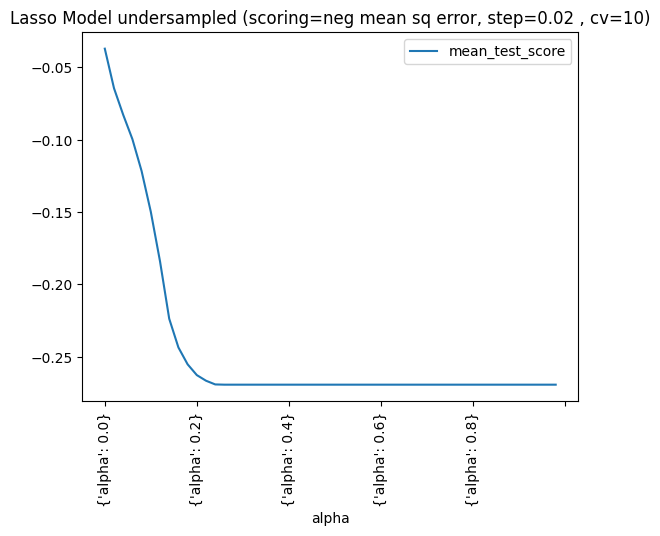

In [92]:
results = pd.DataFrame(lasso_model2.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

results.plot(x = 'params', y = 'mean_test_score')
plt.title('Lasso Model undersampled (scoring=neg mean sq error, step=0.02 , cv=10)')
plt.xticks(rotation = 90)
plt.xlabel('alpha')
plt.show()

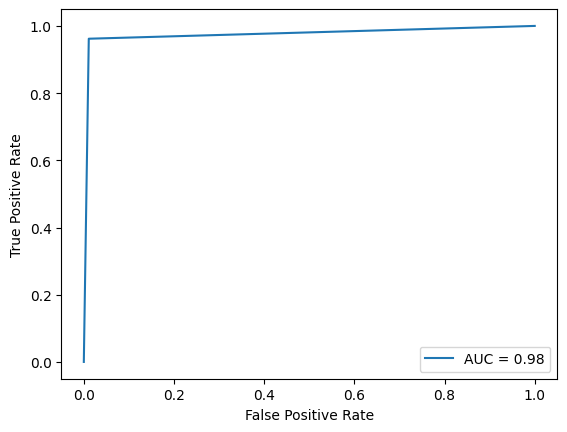

In [93]:
plot_score_roc_auc(y_pred_binary)

In [94]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':lasso_model2.feature_names_in_,'coef':lasso_model2.best_estimator_.coef_})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
0,PROCEED_Diff_standardised,-8.672768,8.672768
139,BorrowerState_UNK,0.939202,0.939202
91,BorrowerState_AK,0.932085,0.932085
52,BusinessType_Self-Employed Individuals,0.454293,0.454293
148,Term_cat_between_24_60,0.363463,0.363463
99,BorrowerState_DC,0.342838,0.342838
151,Term_cat_less_than_24,0.302702,0.302702
9,LoanStatus_Exemption 4,0.201029,0.201029
89,Industry_Utilities,-0.132994,0.132994
114,BorrowerState_ME,-0.123055,0.123055


## Logistic Regression Hyperparameter Tuning

Since Lasso model with undersampling performed well and provided explainable coefficients, but at an alpha value of 0 which is a logistic regression, we directly attempt a logistic regression with param l1 and l2 penalties.

In [95]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(solver='saga')

param_grid = {
    'penalty': ['l1', 'l2', None],
    'C': np.logspace(-3, 3, 7)}

logistic_regression = GridSearchCV(logistic_regression, param_grid = param_grid, scoring = 'roc_auc', cv = 10)

logistic_regression.fit(X_train_undersampled, y_train_undersampled)

# predict y values based on lasso model
y_pred = logistic_regression.predict(X_test)

# note that prediction output is 0 < y < 1, hence convert into binary
y_pred_binary = [1 if i > 0.5 else 0 for i in y_pred]

In [96]:
# save model
joblib.dump(logistic_regression, 'logistic_model_undersampled.pkl')

['logistic_model_undersampled.pkl']

In [97]:
logistic_regression = joblib.load('logistic_model_undersampled.pkl')

In [98]:
# generate accuracy and classification report
accuracy = accuracy_score(y_test, y_pred_binary)
classification_report_result = classification_report(y_test, y_pred_binary)

print(f"Best param: {logistic_regression.best_params_}")
print(f'Accuracy: {accuracy}')
print(f'Classification Report:\n{classification_report_result}')
print(confusion_matrix(y_test, y_pred_binary))

Best param: {'C': 100.0, 'penalty': 'l1'}
Accuracy: 0.9803356915255823
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    192274
           1       0.03      0.99      0.05       105

    accuracy                           0.98    192379
   macro avg       0.51      0.99      0.52    192379
weighted avg       1.00      0.98      0.99    192379

[[188492   3782]
 [     1    104]]


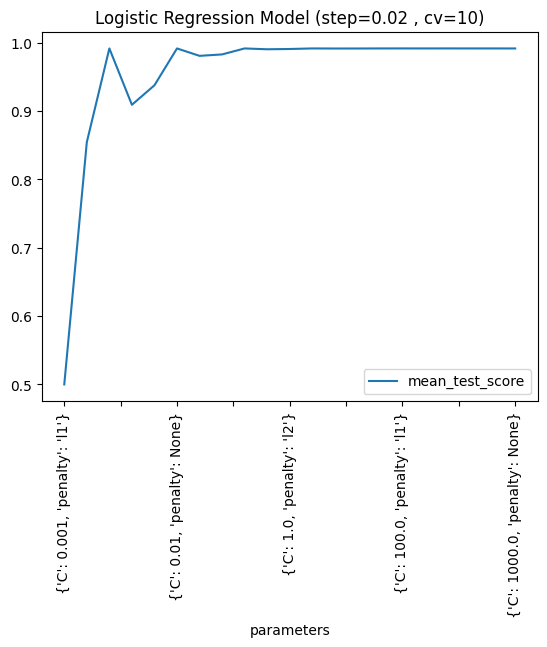

In [99]:
results = pd.DataFrame(logistic_regression.cv_results_)[['params', 'mean_test_score', 'rank_test_score']]

results.plot(x = 'params', y = 'mean_test_score')
plt.title('Logistic Regression Model (step=0.02 , cv=10)')
plt.xticks(rotation = 90)
plt.xlabel('parameters')
plt.show()

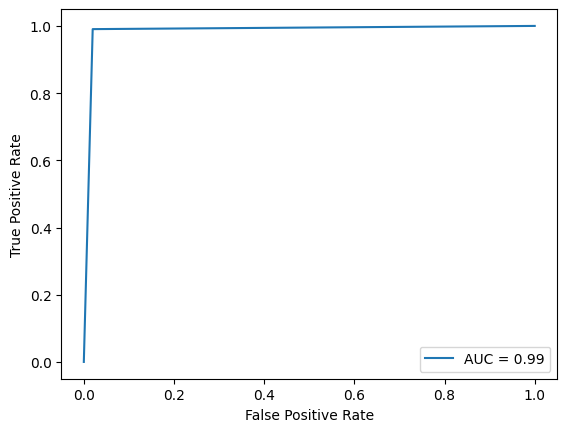

In [100]:
plot_score_roc_auc(y_pred_binary)

In [101]:
# top 20 feature coefficients
feature_coef = pd.DataFrame({'feature':logistic_regression.feature_names_in_,'coef':logistic_regression.best_estimator_.coef_.flatten()})
feature_coef['abs_coef'] = abs(feature_coef['coef'])
feature_coef.sort_values(by = 'abs_coef', ascending = False).head(20)

,feature,coef,abs_coef
91,BorrowerState_AK,9.228940,9.228940
139,BorrowerState_UNK,3.511062,3.511062
10,LoanStatus_Paid in Full,-1.837010,1.837010
9,LoanStatus_Exemption 4,1.665841,1.665841
148,Term_cat_between_24_60,1.501413,1.501413
144,BorrowerState_WA,-1.288833,1.288833
149,Term_cat_is_24,-1.253486,1.253486
96,BorrowerState_CA,-1.087111,1.087111
107,BorrowerState_IL,-1.054078,1.054078
67,isAfterBiden_1,-0.965984,0.965984
